This notebook requires the file `lc_data_with_returns.pkl` to be uploaded before running the code

### **Alternate Clustering: Hierarchical Clustering Analysis**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_pickle('lc_data_with_returns.pkl')
print(f"Loaded data with {len(df)} loans.")

clustering_features = [
    'loan_amnt', 'funded_amnt', 'term_months', 'int_rate', 'installment',
    'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util',
    'return_m1_pess', 'return_m2_opt', 'return_m3_1.2'
]

clustering_features = [col for col in clustering_features if col in df.columns]
print(f"Selected {len(clustering_features)} features.")

cluster_data = df[clustering_features].copy()

for col in cluster_data.columns:
    if cluster_data[col].isnull().sum() > 0:
        cluster_data[col] = cluster_data[col].fillna(cluster_data[col].median())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

sample_size = 1000
sample_indices = np.random.choice(scaled_data.shape[0], sample_size, replace=False)
sample_data = scaled_data[sample_indices]

print(f"Sampled {sample_size} points for dendrogram.")

Loaded data with 656724 loans.
Selected 14 features.
Sampled 1000 points for dendrogram.


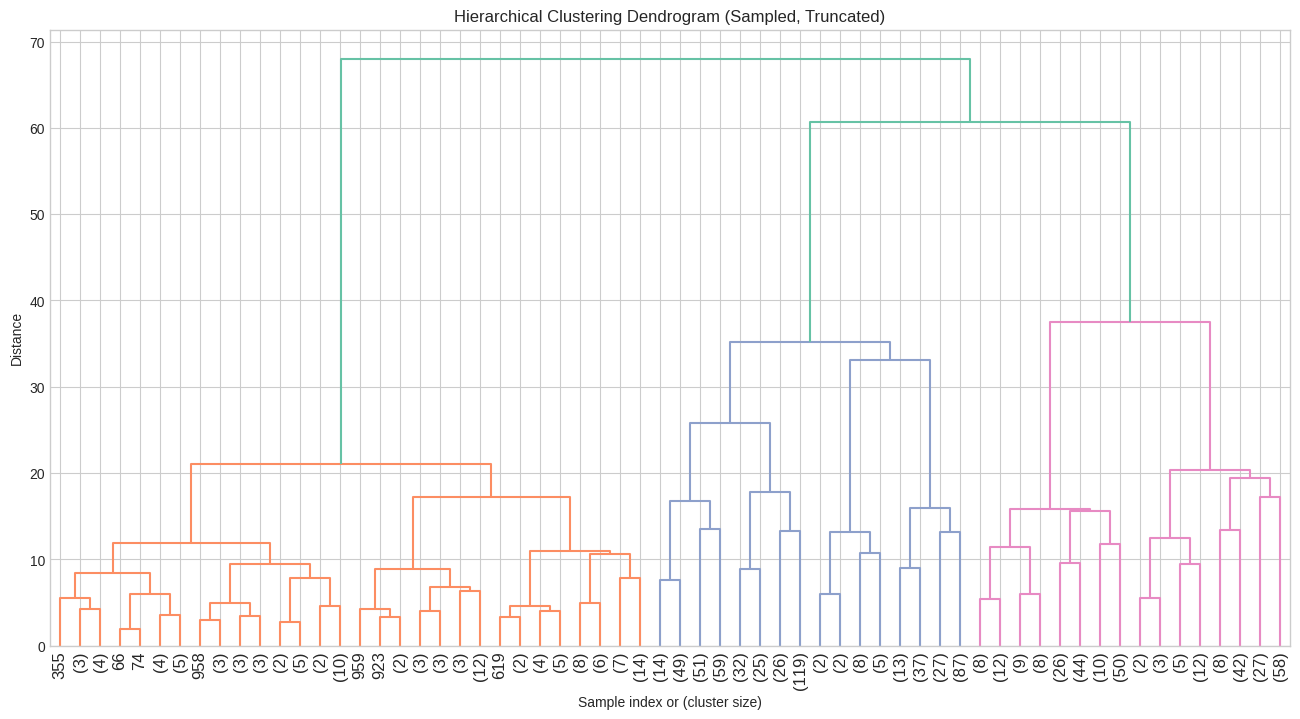

Crosstab: Sample Hierarchical Clusters vs. Grades

grade                 A    B    C   D   E   F  G
sample_hier_cluster                             
0                    62   62   33  15   7   0  2
1                    81  123  112  43  11   5  0
2                     2   38   45  42  17  12  1
3                     3   20   53  49  32   7  3
4                     9   22   42  34  12   0  1


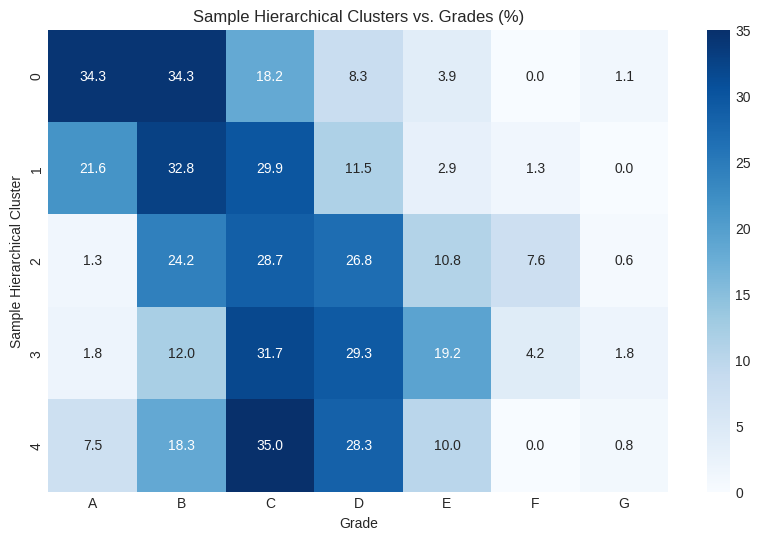

In [ ]:
linked_sample = linkage(sample_data, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linked_sample,
           truncate_mode='level',
           p=5,
           leaf_rotation=90.,
           leaf_font_size=12.)
plt.title('Hierarchical Clustering Dendrogram (Sampled, Truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

sample_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
sample_cluster_labels = sample_cluster.fit_predict(sample_data)

sample_df = df.iloc[sample_indices].copy()
sample_df['sample_hier_cluster'] = sample_cluster_labels

if 'grade' in sample_df.columns:
    ctab = pd.crosstab(sample_df['sample_hier_cluster'], sample_df['grade'])
    print("Crosstab: Sample Hierarchical Clusters vs. Grades\n")
    print(ctab)

    norm_ctab = pd.crosstab(sample_df['sample_hier_cluster'], sample_df['grade'], normalize='index') * 100
    plt.figure(figsize=(10, 6))
    sns.heatmap(norm_ctab, annot=True, fmt='.1f', cmap='Blues')
    plt.title('Sample Hierarchical Clusters vs. Grades (%)')
    plt.xlabel('Grade')
    plt.ylabel('Sample Hierarchical Cluster')
    plt.show()

We applied hierarchical clustering (Ward’s linkage) on a sample of 1,000 loans from the Lending Club dataset, using the same 14 features as in the K-Means analysis. The dendrogram revealed five primary clusters, aligning with the previous choice of k=5 in K-Means for consistency.

The cross-tab between the hierarchical clusters and LendingClub grades showed partial overlap, though the mapping was not perfect. Some clusters had a higher concentration of A and B grade loans, while others mixed across grades. The normalized heatmap confirmed this, highlighting that grades do not align cleanly with the clusters.

Compared to K-Means, hierarchical clustering uncovered similar patterns, reinforcing the observation that LendingClub grades only partially reflect the underlying feature groupings. The hierarchical structure additionally shows the relationships between clusters at different levels of similarity, offering more flexibility in understanding borrower segmentation.

### **PCA Analysis on Grade A and Grade G Loans**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

grade_a_data = df[df['grade'] == 'A'].copy()
grade_g_data = df[df['grade'] == 'G'].copy()

pca_features = [
    'loan_amnt', 'funded_amnt', 'term_months', 'int_rate', 'installment',
    'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util',
    'return_m1_pess', 'return_m2_opt', 'return_m3_1.2'
]

pca_features = [col for col in pca_features if col in df.columns]

def run_pca(subset, label):

    pca_data = subset[pca_features].copy()
    for col in pca_data.columns:
        if pca_data[col].isnull().sum() > 0:
            pca_data[col] = pca_data[col].fillna(pca_data[col].median())


    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pca_data)


    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    explained_variance = pca.explained_variance_ratio_

    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(len(pca_features))],
        index=pca_features
    )

    print(f"\n{label} PCA Summary")
    for i, var in enumerate(explained_variance[:5]):
        print(f"PC{i+1}: {var:.4f} variance explained")
    display(loadings.iloc[:, :3].round(3))
    return explained_variance, loadings

# Run PCA for Grade A and Grade G
a_variance, a_loadings = run_pca(grade_a_data, 'Grade A')
g_variance, g_loadings = run_pca(grade_g_data, 'Grade G')


Grade A PCA Summary
PC1: 0.2413 variance explained
PC2: 0.2123 variance explained
PC3: 0.0961 variance explained
PC4: 0.0936 variance explained
PC5: 0.0801 variance explained


,PC1,PC2,PC3
loan_amnt,0.511,-0.144,-0.074
funded_amnt,0.511,-0.144,-0.074
term_months,0.059,0.017,0.104
int_rate,0.034,0.050,0.091
installment,0.505,-0.146,-0.090
annual_inc,0.208,-0.065,-0.184
dti,0.037,-0.019,0.709
delinq_2yrs,-0.007,0.001,0.041
open_acc,0.108,-0.063,0.615
revol_bal,0.264,-0.071,0.212



Grade G PCA Summary
PC1: 0.2627 variance explained
PC2: 0.2148 variance explained
PC3: 0.1088 variance explained
PC4: 0.0793 variance explained
PC5: 0.0742 variance explained


,PC1,PC2,PC3
loan_amnt,0.499,-0.074,-0.068
funded_amnt,0.499,-0.074,-0.068
term_months,0.203,-0.030,-0.032
int_rate,-0.014,-0.080,-0.171
installment,0.487,-0.076,-0.075
annual_inc,0.338,-0.017,-0.102
dti,-0.064,-0.009,0.588
delinq_2yrs,0.041,-0.035,-0.173
open_acc,0.162,-0.027,0.389
revol_bal,0.240,0.016,0.439



Grade A - Top contributing features to PC1:
loan_amnt      0.510808
funded_amnt    0.510808
installment    0.504512
Name: PC1, dtype: float64

Grade G - Top contributing features to PC1:
funded_amnt    0.499485
loan_amnt      0.499485
installment    0.487354
Name: PC1, dtype: float64


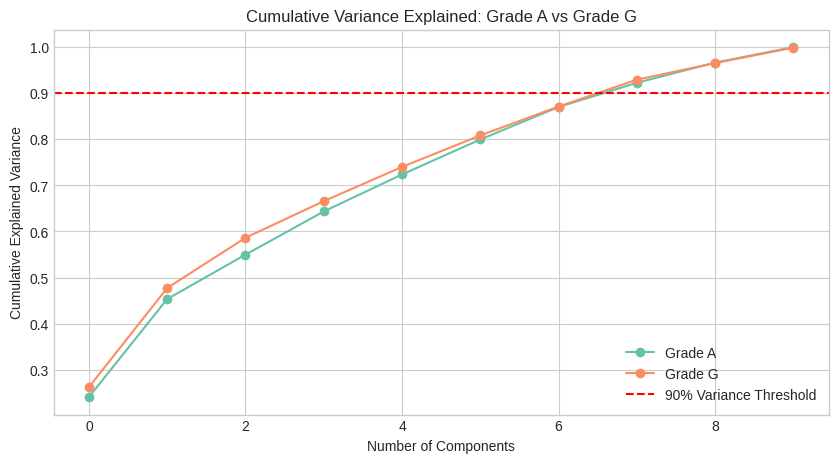

In [ ]:
print("\nGrade A - Top contributing features to PC1:")
print(a_loadings['PC1'].sort_values(ascending=False).head(3))

print("\nGrade G - Top contributing features to PC1:")
print(g_loadings['PC1'].sort_values(ascending=False).head(3))

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(a_variance[:10]), label='Grade A', marker='o')
plt.plot(np.cumsum(g_variance[:10]), label='Grade G', marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title('Cumulative Variance Explained: Grade A vs Grade G')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

The PCA analysis on Grade A and Grade G loans reveals both similarities and subtle differences in feature importance across loan grades. For both grades, PC1 primarily captures loan size, with loan_amnt, funded_amnt, and installment as the top contributing features. However, Grade G loans show slightly higher variance explained in the first principal component (26.27% vs. 24.13%) and greater emphasis on annual_inc, indicating income plays a more prominent role for riskier loans. The cumulative variance plots show both grades require around 7 components to explain 90% of variance, confirming the complexity of the data. Despite differences in credit grades, both segments display similar patterns in principal component loadings, suggesting LendingClub grades align closely with underlying loan characteristics. For investors, this suggests that PCA can reinforce grade-based insights but may not offer distinct feature patterns between the safest and riskiest loans without deeper analysis.